In [1]:
import os
from time import time
import numpy as np
import sys
sys.path.append('../')

from utils.codification_cnn import CNNLayer, NNLayer, FitnessCNNParallel, ChromosomeCNN
from utils.datamanager import DataManager
from utils.codification_skip_lr import ChromosomeSkipLr, FitnessSkipLr
from utils.codification_skipc import Connections
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA


Using TensorFlow backend.


In [2]:
# Chromosome parameters
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2

ChromosomeSkipLr.grow_prob = mutation_rate
ChromosomeSkipLr.decrease_prob = mutation_rate
ChromosomeSkipLr.max_lr = 0.1
ChromosomeSkipLr.min_lr = 0.0001

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate
CNNLayer.possible_activations = ['relu', 'prelu', 'leakyreLu']

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1
NNLayer.possible_activations = ['relu', 'sigmoid', 'tanh']

CNNLayer.filters_lim = 128

if not 'fondef' in os.path.abspath("."):
    data_folder = '/home/daniel/datasets/MNIST_variations'
    command = 'python ./../train_gen.py'
    verbose = 1
    experiments_folder = '../exps'
    gpus = 1
    epochs = 8
    precise_eps = 15
    num_parents = 0.25
    generations = 5
    population = 20
    precision_individuals = 2
    save = True
    print("Daniel's machine")
else:
    data_folder = '../../../../datasets'
    command = 'python3 ./../train_gen.py'
    verbose = 0
    experiments_folder = '../../exps'
    gpus = 2
    epochs = 8
    precise_eps = 25
    num_parents = 0.25
    generations = 30
    population = 20
    save = True
    precision_individuals = 3
    print("Felipe's machine")

Daniel's machine


In [3]:
experiments_folder = experiments_folder
os.makedirs(experiments_folder, exist_ok=True)

fitness_cnn = FitnessSkipLr()

l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness_cnn)
c = ChromosomeSkipLr(c.cnn_layers, c.nn_layers, Connections.random_connections(len(c.cnn_layers)), 0.5)
    
# dataset params:
data_folder = data_folder
classes = []

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = num_parents
generations = generations
population = population
train_time = 10
maximize_fit = False
stat_val = True
save_progress = save
age_survivors_rate = 0.05
precision_val = True
precision_individuals = precision_individuals

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(population//4)}
p = ps[parents_selector_key]

# Fitness params
epochs = epochs
batch_size = 128
verbose = verbose
base_lr = 0.03
smooth = 0.1
lr_find = False
precise_eps = precise_eps

datasets = ['MB', 'MBI', 'MRB', 'MRD', 'MRDBI']
datasets = ['cifar10']


EVOLVING IN DATASET cifar10 ...

(9600, 32, 32, 3) train samples
(2400, 32, 32, 3) validation samples
(10000, 32, 32, 3) test samples
Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 5
Population size: 20
Folder to save: ../exps/cifar10/genetic/0_2019-07-17-15:38/GA_experiment
num parents: 5
offspring size: 15

Creating Initial population

Start evolution process...

1) best fit: 0.392 in batch time: 14.84 mins
Current winner:
CNN|F:33|K:(3,3)|A:prelu|D:0.562|M:1
CNN|F:15|K:(7,1)|A:leakyreLu|D:0.160|M:0
1
LR:0.00808

Saving... Elapsed saved time: 0.001
2) best fit: 0.392 in batch time: 27.44 mins
Current winner:
CNN|F:33|K:(3,3)|A:prelu|D:0.562|M:1
CNN|F:15|K:(7,1)|A:leakyreLu|D:0.160|M:0
1
LR:0.00808

Saving... Elapsed saved time: 0.001
3) best fit: 0.335 in batch time: 37.05 mins
Current winner:
CNN|F:30|K:(7,3)|A:leakyreLu|D:0.553|M:1
CNN|F:20|K:(7,1)|A:leakyreLu|D:0.489|M:0
CNN|F:95|K:(3,7)|A:leakyreLu|D:0.184|M:0
CNN|F:32|K:(7,1)|A:relu|D

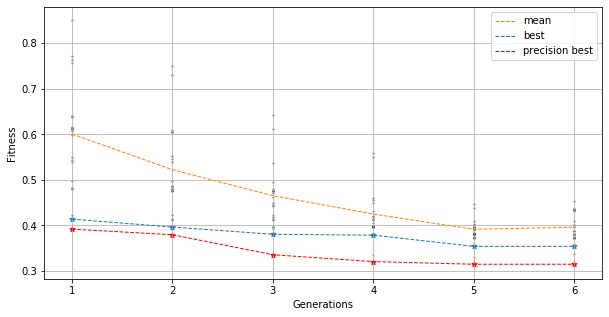

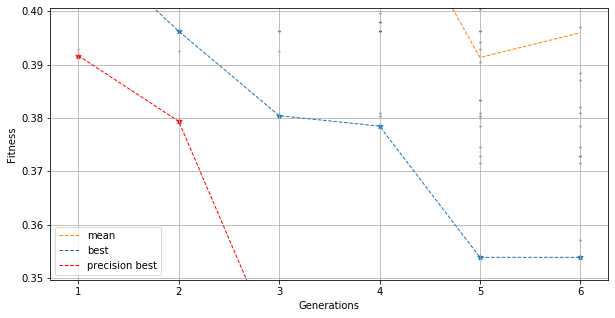

Total elapsed time: 4863.881


In [4]:
for dataset in datasets:
    print("\nEVOLVING IN DATASET %s ...\n" % dataset)
    exp_folder = os.path.join(experiments_folder, dataset)
    folder = os.path.join(exp_folder, 'genetic')
    fitness_folder = exp_folder
    fitness_file = os.path.join(fitness_folder, 'fitness_example') 
    try:
        generational = GenerationalGA.load_genetic_algorithm(folder=folder)
    except FileNotFoundError:
        os.makedirs(folder, exist_ok=True)

        # Load data
        dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder, max_examples=12000)
        data = dm.load_data()
        fitness_cnn.set_params(data=data, verbose=verbose, batch_size=batch_size,
                       epochs=epochs, base_lr=base_lr, smooth_label=smooth, find_lr=lr_find,
                       precise_epochs=precise_eps)

        fitness_cnn.save(fitness_file)

        del dm, data

        fitness = FitnessCNNParallel()
        fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=gpus,
                       fp=32, main_line=command)

        generational = GenerationalGA(fitness=fitness, num_parents=num_parents, chromosome=c, parent_selector=p,
                                  generations=generations, num_population=population, maximize_fitness=maximize_fit, 
                                  training_hours=train_time, folder=folder, statistical_validation=stat_val,
                                  save_progress=save_progress, age_survivors_rate=age_survivors_rate,
                                  precision_val=precision_val, precision_individuals=precision_individuals)

    ti_all = time()
    winner, best_fit, ranking = generational.evolve()
    print("Total elapsed time: %0.3f" % (time() - ti_all))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

0.026967247994862508


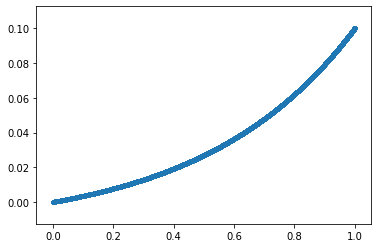

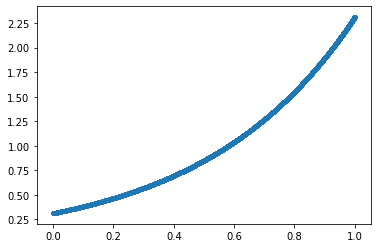

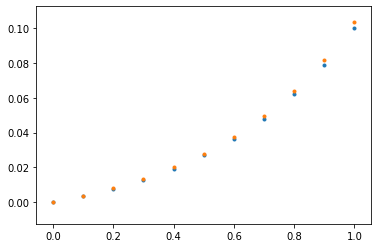

In [6]:

max_val = 0.1
min_val = 0.0001
x = np.random.rand(100000)

def p_(x_):
    return (np.exp(2 * (x_)) - 1) * ((max_val - min_val) / (np.exp(2) - 1)) + min_val

def dp2_(p, dx):
    return np.exp(2*dx) * p + p_(dx)

def dp_(x_):
    return 2 * np.exp(2 * x_)/(np.exp(2) - 1)


p = p_(x)

N=10
X = [0]
DP = [p_(X[0])]
for i in range(N):
    X.append(X[-1] + (1/N))
    DP.append(dp2_(DP[-1], 1/N))
P = [p_(k) for k in X]

print(p_(0.5))
plt.scatter(x,p, marker='.'); plt.show()
plt.scatter(x,dp_(x), marker='.'); plt.show()
plt.scatter(X,P, marker='.')
plt.scatter(X,DP, marker='.'); plt.show()

0.03437768600222696 0.09999918462011005 0.00010018294370339752


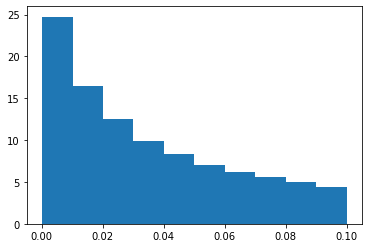

In [7]:
print(np.mean(p), np.max(p), np.min(p))
plt.hist(p, density=True)
plt.show()

In [8]:
import random

def gauss_mutation(val, max_val, min_val, int_=True):
        m = 0
        s = (max_val - min_val) / 20
        new_val = val + random.gauss(m, s)
        if int_:
            new_val = int(new_val)
        if new_val < min_val:
            new_val = 2 * min_val - new_val
        elif new_val > max_val:
            new_val = max_val - (new_val - max_val)
        if new_val > max_val or new_val < min_val:
            new_val = gauss_mutation(val, max_val, min_val, int_)
        return new_val

0.7 0.7000151363060715 0.9595369614927407 0.4832814440784238


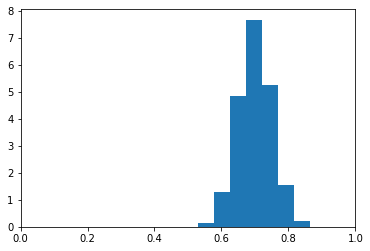

0.04787145042424457 0.048192163660664325 0.09101843812006966 0.025569555988488132


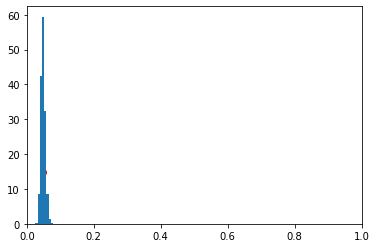

In [9]:
val = 0.7
gm = [gauss_mutation(val, 1, 0, False) for xi in x]
p_gm = p_(np.array(gm))
print(val, np.mean(gm), np.max(gm), np.min(gm))

plt.hist(gm, density=True); plt.xlim([0,1]); plt.show()
print(p_(val), np.mean(p_gm), np.max(p_gm), np.min(p_gm))
plt.hist(p_gm, density=True); plt.scatter(p_(val), 15, c='r'); plt.xlim([0,1]); plt.show()

In [10]:
def cross_lr_gen(lr_gen_1, lr_gen_2):
    b = np.random.rand()
    return lr_gen_1 * b + (1 - b) * lr_gen_2

In [11]:
print(cross_lr_gen(0.5,0.8))

0.5836320470436522
